# Prerequisites

Please make sure to follow these steps to start using TimeGEN: 

* Register for a valid Azure account with subscription 
* Make sure you have access to [Azure AI Studio](https://learn.microsoft.com/en-us/azure/ai-studio/what-is-ai-studio?tabs=home)
* Create a project and resource group
* Select `TimeGEN-1`.

    > Notice that some models may not be available in all the regions in Azure AI and Azure Machine Learning. On those cases, you can create a workspace or project in the region where the models are available and then consume it with a connection from a different one. To learn more about using connections see [Consume models with connections](https://learn.microsoft.com/en-us/azure/ai-studio/how-to/deployments-connections)

* Deploy with "Pay-as-you-go"

Once deployed successfully, you should be assigned for an API endpoint and a security key for inference.

To complete this tutorial, you will need to:

* Install `nixtla` and `pandas`:

    ```bash
    pip install nixtla pandas
    ```

# Anomaly detection

Anomaly detection is task of detecting abnormal points, points that deviate from the normal behaviour of the general series. This is crucial in many application, such as cybersecurity or equipment monitoring.

In this tutorial, we explore in detail the anomaly detection capability of TimeGEN.

To complete this tutorial, you will need to:

* Install `nixtla` and `pandas`:

    ```bash
    pip install nixtla pandas
    ```

## Import packages

First, we import the required packages for this tutorial and create an instance of `NixtlaClient`.

In [3]:
# import load_env
from dotenv import load_dotenv
from os import environ as env

load_dotenv()

True

In [4]:
import pandas as pd
from nixtla import NixtlaClient

In [5]:
# Instantiate the Nixtla Client
base_url = env.get("NIXTLA_BASE_URL")
api_key = env.get("NIXTLA_API_KEY")
if not api_key:
    raise Exception("A key should be provided to invoke the endpoint")

nixtla_client = NixtlaClient(
    base_url=base_url,
    api_key=api_key,
)

## Load dataset

Now, let's load the dataset for this tutorial. We use the Peyton Manning dataset which tracks the visits to the Wikipedia page of Peyton Mannig.

In [6]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/peyton_manning.csv"
)

df.head()

,timestamp,value
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


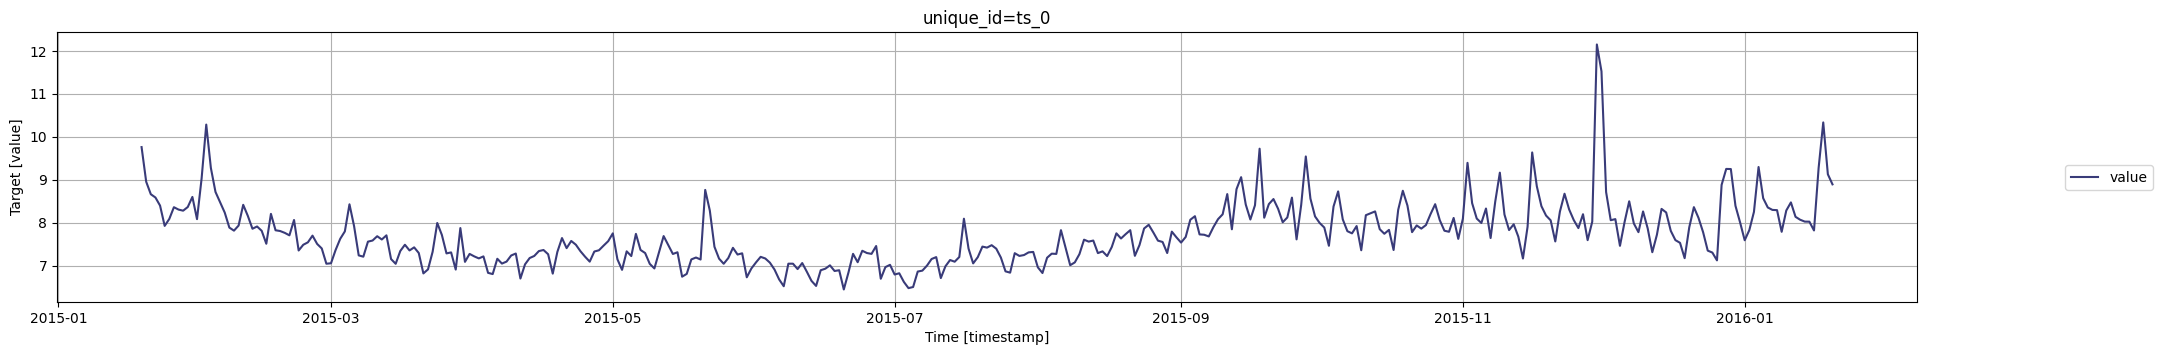

In [7]:
nixtla_client.plot(
    df, time_col="timestamp", target_col="value", max_insample_length=365
)

## Anomaly detection

We now perform anomaly detection. By default, TimeGEN uses a 99% confidence interval. If a point falls outisde of that interval, it is considered to be an anomaly.

In [8]:
anomalies_df = nixtla_client.detect_anomalies(
    df,
    time_col="timestamp",
    target_col="value",
    freq="D",
)

anomalies_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


,timestamp,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99
0,2008-08-30,0,5.610880,7.515554,9.420229
1,2008-08-31,0,5.866223,7.770897,9.675572
2,2008-09-01,0,6.224528,8.129203,10.033877
3,2008-09-02,0,6.099887,8.004561,9.909236
4,2008-09-03,0,6.059255,7.963930,9.868604


As you can see, 0 is assigned to "normal" values, as they fall inside the confidence interval. A label of 1 is then assigned to abnormal points.

We can also plot the anomalies using `NixtlaClient`.

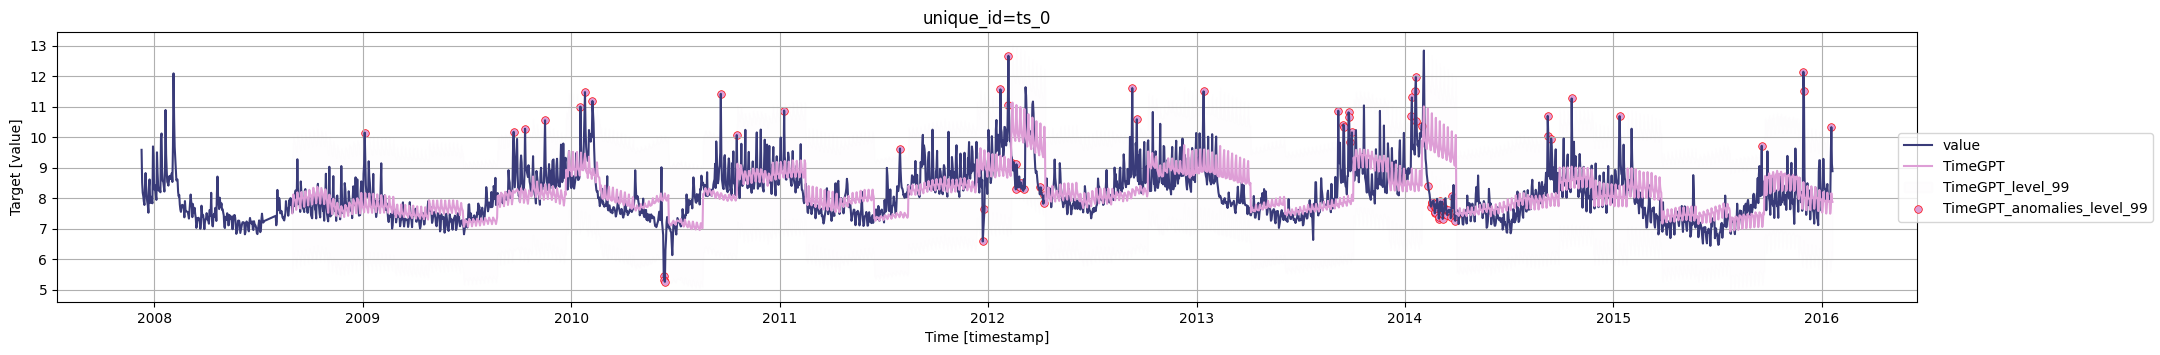

In [9]:
nixtla_client.plot(df, anomalies_df, time_col="timestamp", target_col="value")

## Anomaly detection with exogenous features

Previously, we performed anomaly detection without using any exogenous features. Now, it is possible to create features specifically for this scnenario to inform the model in its task of anomaly detection.

Here, we create date features that can be used by the model.

This is done using the `date_features` argument. We can set it to `True` and it will generate all possible features from the given dates and frequency of the data. Alternatively, we can specify a list of features that we want. In this case, we want only features at the *month* and *year* level.

In [10]:
anomalies_df_x = nixtla_client.detect_anomalies(
    df,
    time_col="timestamp",
    target_col="value",
    freq="D",
    date_features=["month", "year"],
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...
INFO:nixtla.nixtla_client:Using the following exogenous variables: month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11, month_12, year_2007, year_2008, year_2009, year_2010, year_2011, year_2012, year_2013, year_2014, year_2015, year_2016


Then, we can plot the weights of each feature to understand its impact on anomaly detection.

<Axes: ylabel='features'>

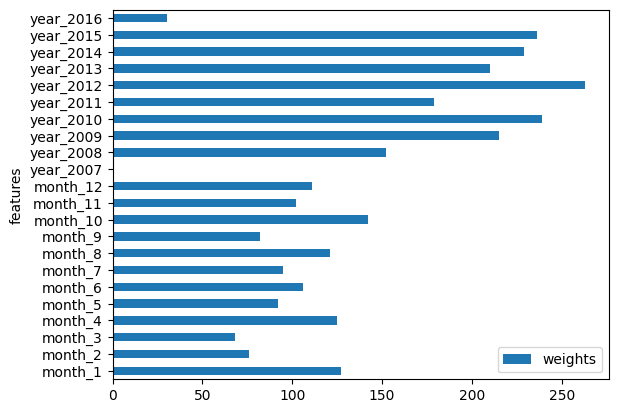

In [11]:
nixtla_client.weights_x.plot.barh(x="features", y="weights")

## Modifying the confidence intervals

We can tweak the confidence intervals using the `level` argument. This takes any values between 0 and 100, including decimal numbers.

Reducing the confidence interval resutls in more anomalies being detected, while increasing it will reduce the number of anomalies.

Here, for example, we reduce the interval to 70%, and we will notice more anomalies being plotted (red dots).

In [12]:
anomalies_df = nixtla_client.detect_anomalies(
    df,
    time_col="timestamp",
    target_col="value",
    freq="D",
    level=70,
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


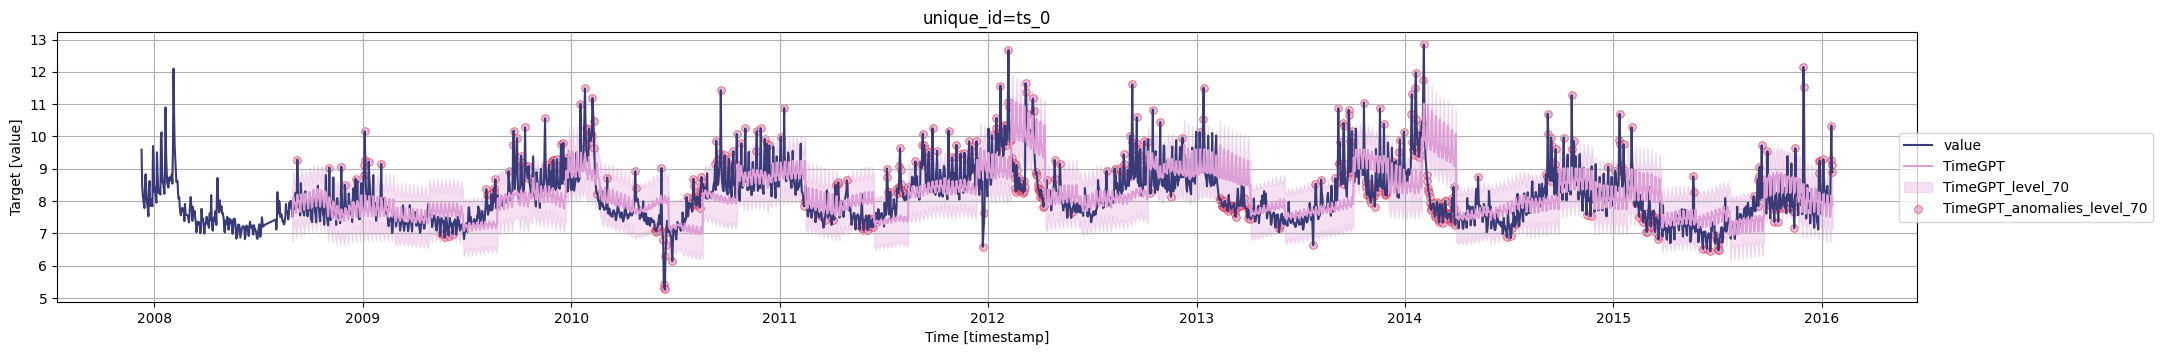

In [13]:
nixtla_client.plot(df, anomalies_df, time_col="timestamp", target_col="value")